In [4]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [5]:
from transformers import AutoModelForVision2Seq, AutoTokenizer, AutoProcessor
import numpy as np
from PIL import Image
import lens

torch.set_grad_enabled(False)

# Загрузка модели и процессора
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-500M-Instruct",
    torch_dtype=torch.bfloat16,
    output_attentions=True
).to(mps_device)

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


In [6]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "What does the man hold?"}
        ]
    },
    {"role": "assistant", "content": [{"type" : "text", "text": "He is holding a "}]}
]

#image = np.random.rand(3,512,512)
image = Image.open('data/bashkir.jpg')
#inputs = processor(text=["'<|image_pad|>'На картинке изображен "], images=[image], padding=True, return_tensors="pt")
#processor.decode(inputs["input_ids"][0])
prompt = processor.apply_chat_template(messages, continue_final_message=True, add_generation_prompt=False)
inputs = processor(text=prompt, images=[image], return_tensors="pt").to(mps_device)

In [7]:
model

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(1024, 768)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-11): 12 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_features=7

In [8]:
logit_lens = lens.LogitLens(model.model.text_model.layers, model.lm_head, tokenizer=processor.tokenizer, processor=processor, output_attentions=True)
logit_lens.register()

vision_lens = lens.LogitLens(model.model.vision_model.encoder.layers, model.lm_head, tokenizer=processor.tokenizer, processor=processor)
vision_lens.register()

projector_lens = lens.LogitLens(model.model.connector, model.lm_head, tokenizer=processor.tokenizer, processor=processor)
projector_lens.register()

vision_embedding_lens = lens.LogitLens(model.model.vision_model.embeddings.patch_embedding, model.lm_head, tokenizer=processor.tokenizer, processor=processor)
vision_embedding_lens.register()

In [9]:
import torch.nn.functional as F

outputs = model(**inputs)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


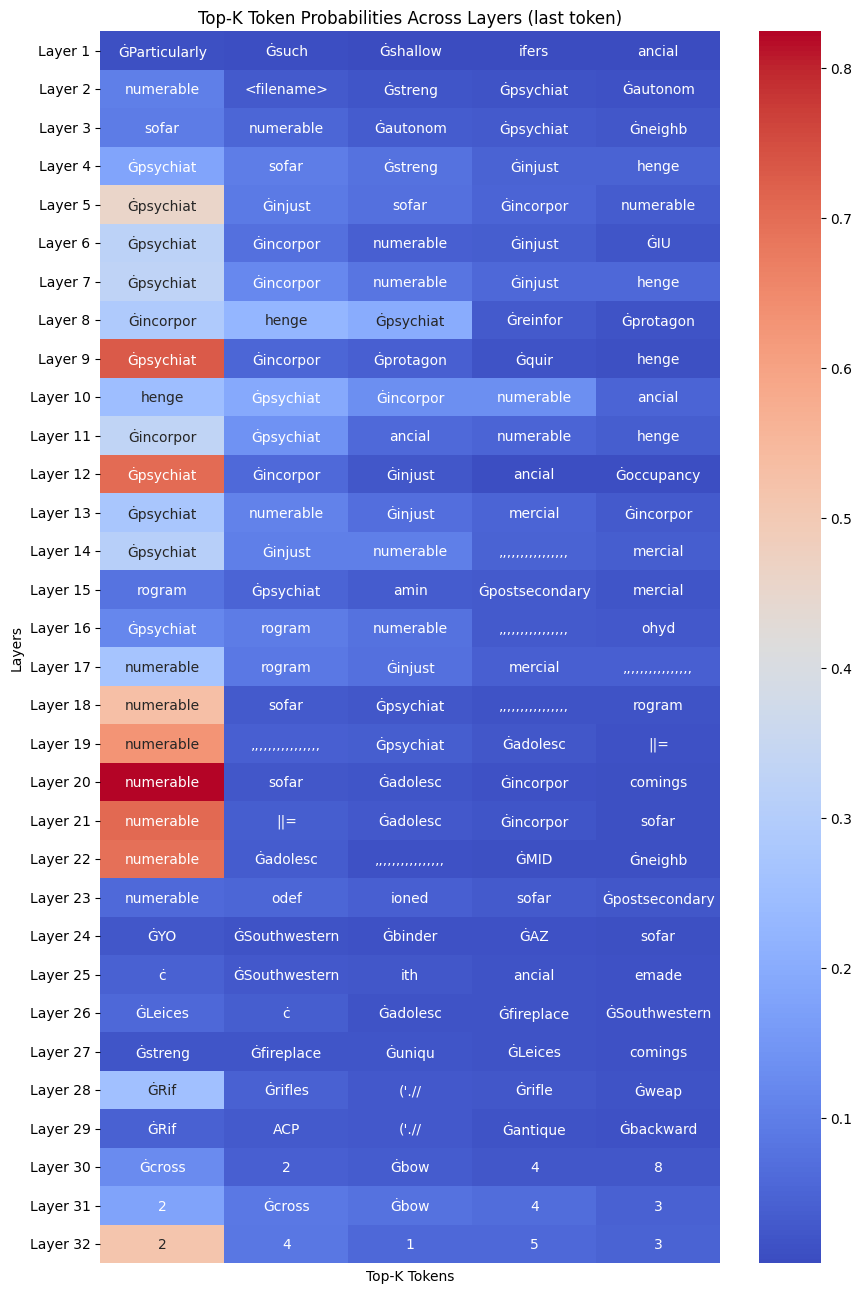

[['ĠParticularly' 'Ġsuch' 'Ġshallow' 'ifers' 'ancial']
 ['numerable' '<filename>' 'Ġstreng' 'Ġpsychiat' 'Ġautonom']
 ['sofar' 'numerable' 'Ġautonom' 'Ġpsychiat' 'Ġneighb']
 ['Ġpsychiat' 'sofar' 'Ġstreng' 'Ġinjust' 'henge']
 ['Ġpsychiat' 'Ġinjust' 'sofar' 'Ġincorpor' 'numerable']
 ['Ġpsychiat' 'Ġincorpor' 'numerable' 'Ġinjust' 'ĠIU']
 ['Ġpsychiat' 'Ġincorpor' 'numerable' 'Ġinjust' 'henge']
 ['Ġincorpor' 'henge' 'Ġpsychiat' 'Ġreinfor' 'Ġprotagon']
 ['Ġpsychiat' 'Ġincorpor' 'Ġprotagon' 'Ġquir' 'henge']
 ['henge' 'Ġpsychiat' 'Ġincorpor' 'numerable' 'ancial']
 ['Ġincorpor' 'Ġpsychiat' 'ancial' 'numerable' 'henge']
 ['Ġpsychiat' 'Ġincorpor' 'Ġinjust' 'ancial' 'Ġoccupancy']
 ['Ġpsychiat' 'numerable' 'Ġinjust' 'mercial' 'Ġincorpor']
 ['Ġpsychiat' 'Ġinjust' 'numerable' ',,,,,,,,,,,,,,,,' 'mercial']
 ['rogram' 'Ġpsychiat' 'amin' 'Ġpostsecondary' 'mercial']
 ['Ġpsychiat' 'rogram' 'numerable' ',,,,,,,,,,,,,,,,' 'ohyd']
 ['numerable' 'rogram' 'Ġinjust' 'mercial' ',,,,,,,,,,,,,,,,']
 ['numerable' 's

In [10]:
logit_lens.visualize_text_predictions(norm=model.model.text_model.norm, top_k=5)

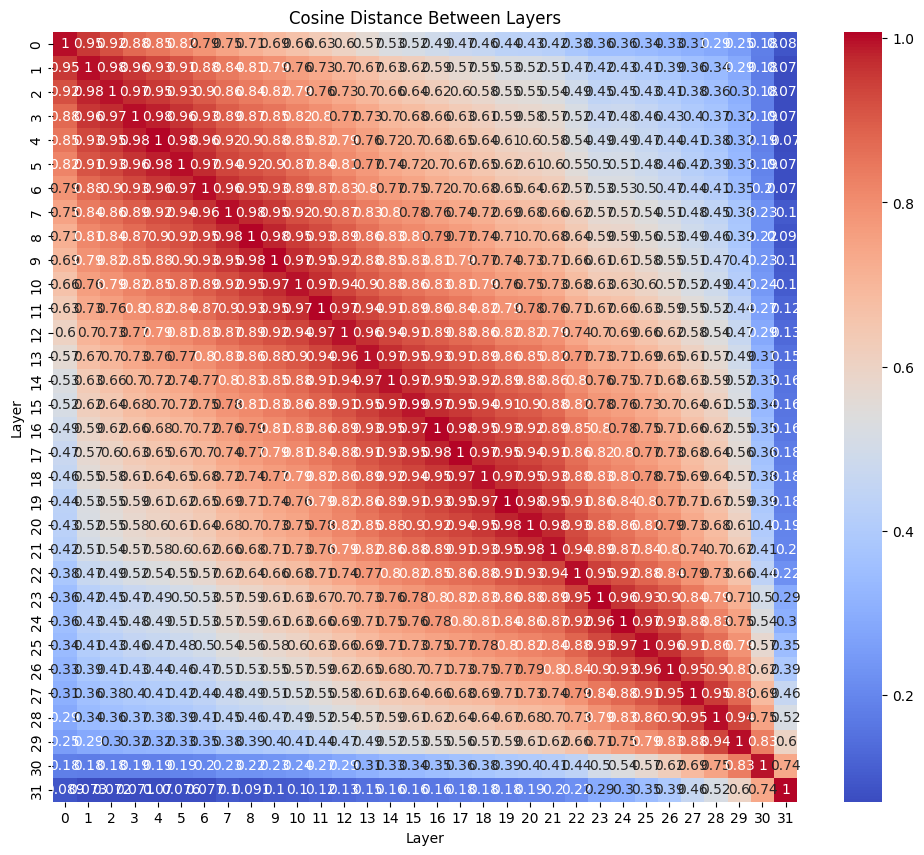

In [11]:
logit_lens.cosine_distance_heatmap(norm = model.model.text_model.norm)

In [12]:
logit_lens.uncertainity(norm = model.model.text_model.norm)

np.float32(0.6728859)

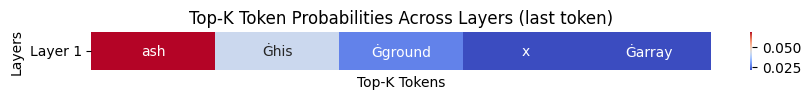

[['ash' 'Ġhis' 'Ġground' 'x' 'Ġarray']]


In [13]:
projector_lens.visualize_text_predictions(norm=model.model.text_model.norm, top_k=5)

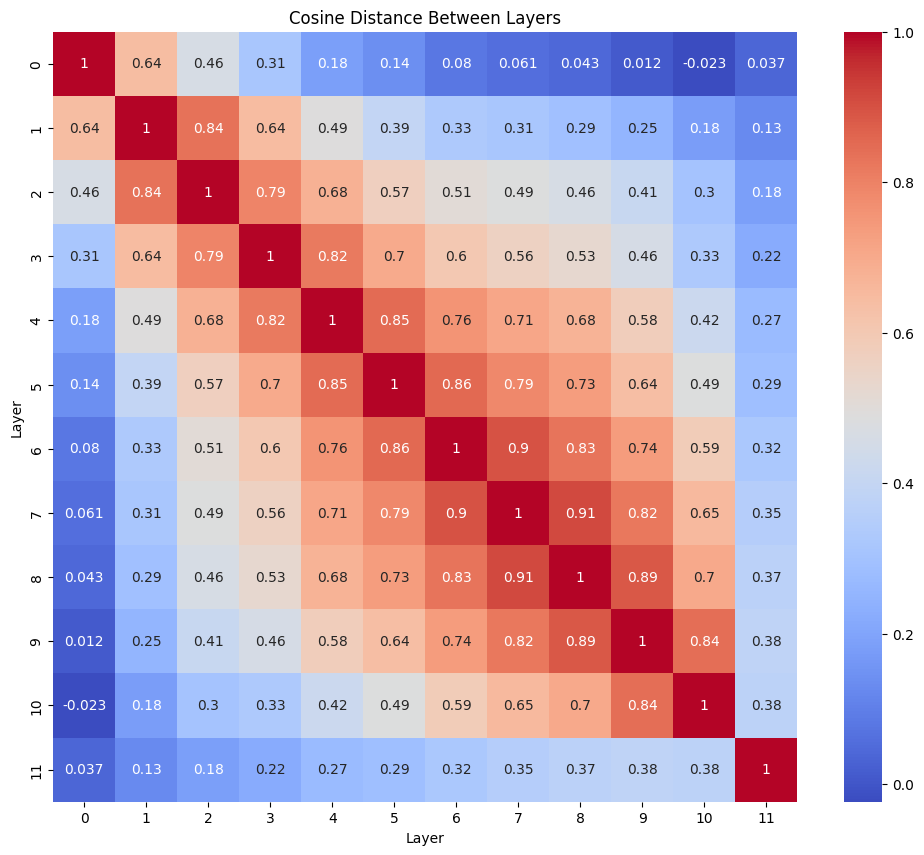

In [14]:
vision_lens.cosine_distance_heatmap(norm = model.model.vision_model.post_layernorm)

In [15]:
pixel_mask = (inputs['input_ids'] == processor.tokenizer.encode(processor.image_token.content)[0])[0]

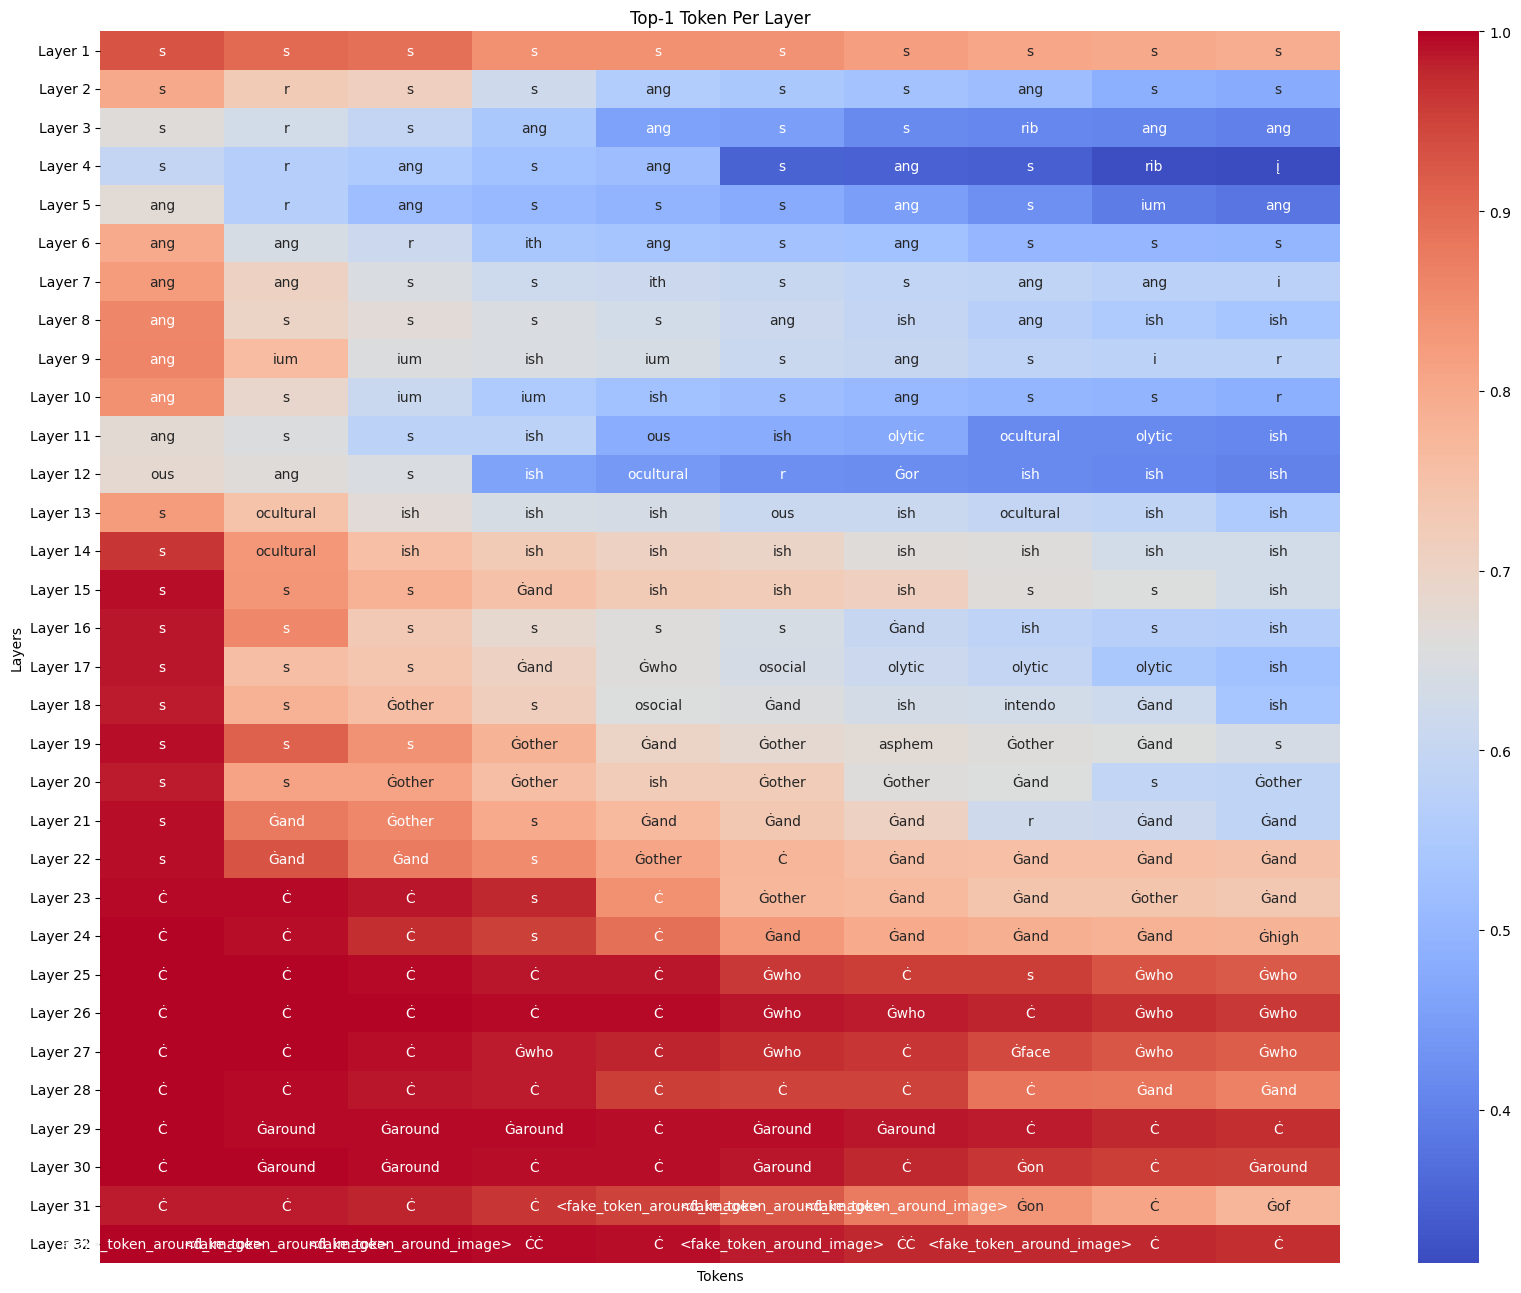

In [16]:
logit_lens.print_top1_per_layer(norm = model.model.text_model.norm, mask=pixel_mask) # vision tokens

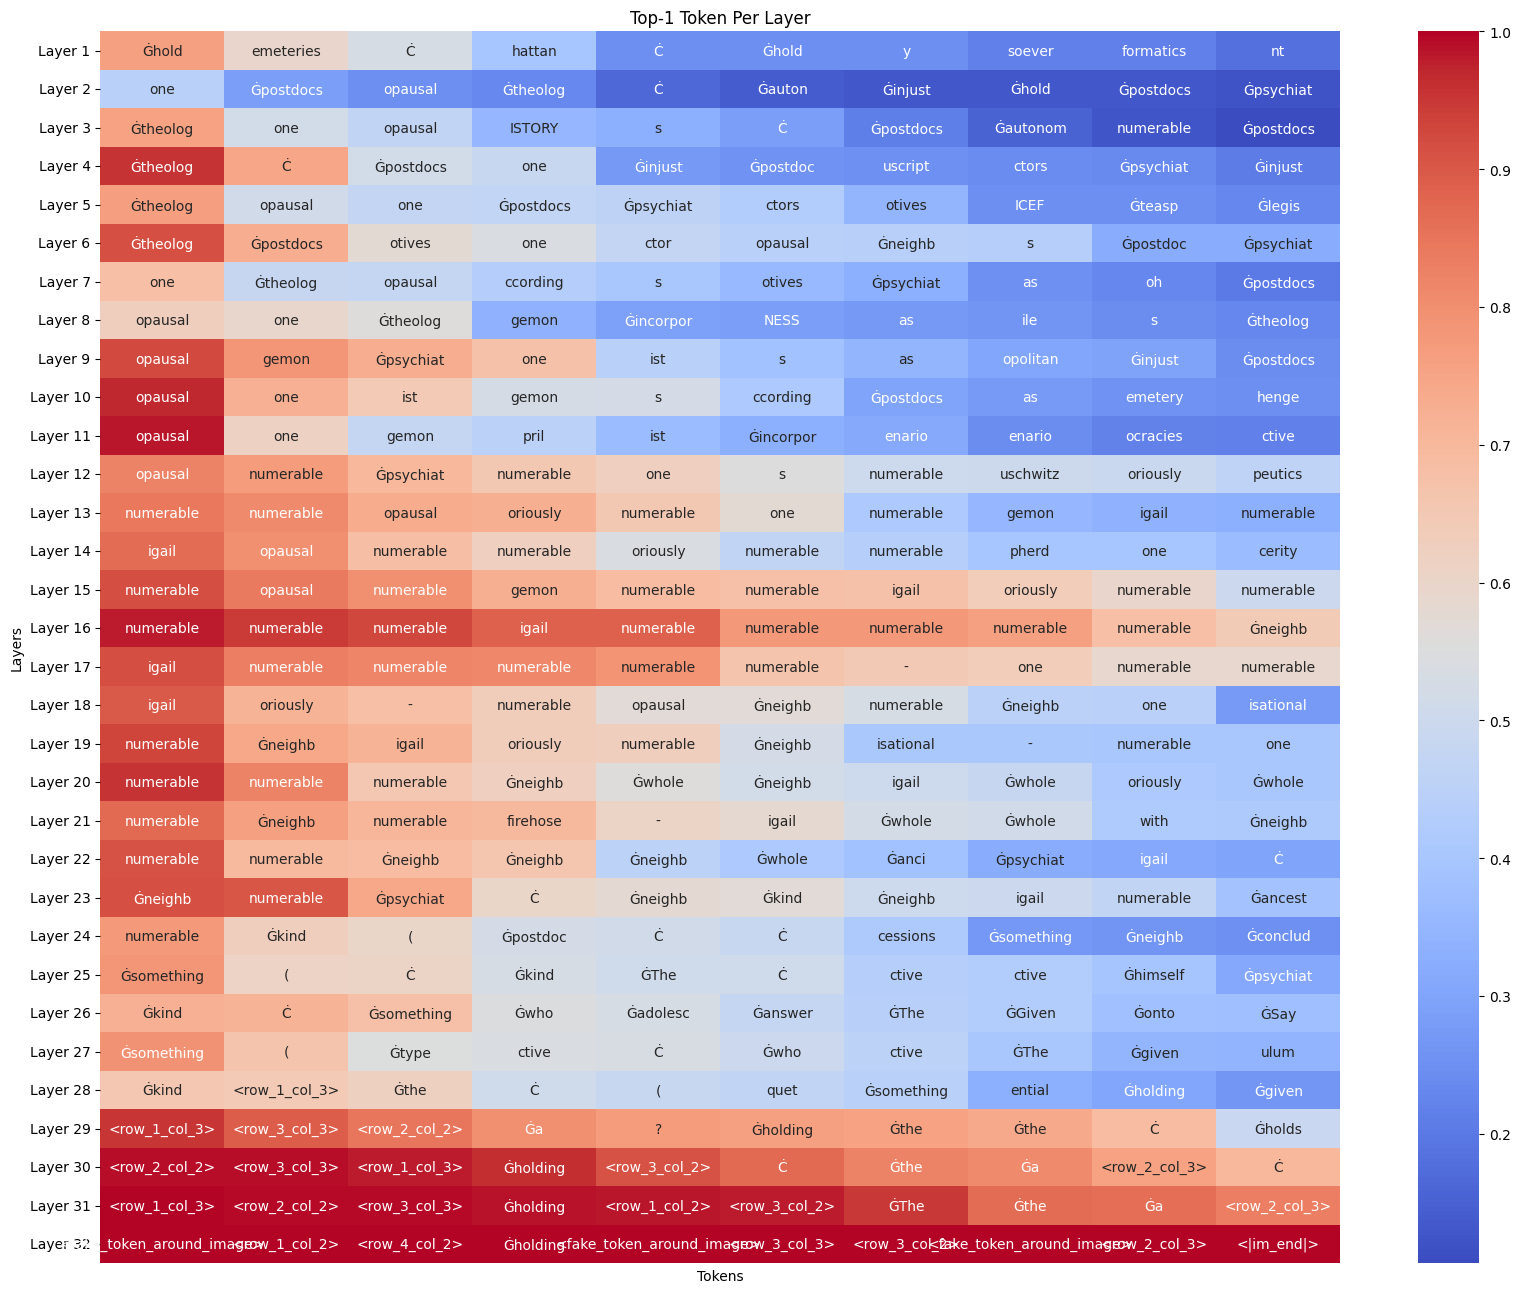

In [17]:
logit_lens.print_top1_per_layer(norm = model.model.text_model.norm, mask=~pixel_mask)

In [18]:
sum(pixel_mask)

tensor(832, device='mps:0')

In [19]:
np.array([x.cpu().float() for x in logit_lens.activations.values()], dtype=np.float16)

array([[[[-5.5469e-01, -8.3984e-01, -1.3594e+00, ..., -1.7422e+00,
          -1.1406e+00,  9.5703e-01],
         [-5.7031e-01, -7.3828e-01,  3.4570e-01, ..., -9.2773e-02,
          -7.5000e-01, -1.4062e-01],
         [ 1.7285e-01,  9.8145e-02, -2.4023e-01, ..., -2.1094e-01,
          -3.7695e-01,  5.0391e-01],
         ...,
         [ 5.2344e-01,  5.1172e-01, -1.6113e-02, ...,  5.3125e-01,
           2.2812e+00,  1.0312e+00],
         [-5.5469e-01,  4.9023e-01,  4.7607e-02, ...,  1.6309e-01,
           2.7969e+00,  7.1875e-01],
         [ 1.6992e-01,  1.0938e-01,  9.4238e-02, ..., -1.7871e-01,
          -6.3281e-01,  3.2422e-01]]],


       [[[-8.6719e-01, -5.0781e-01, -1.7109e+00, ..., -1.2188e+00,
          -1.8125e+00,  1.4219e+00],
         [-8.2031e-01, -1.4141e+00,  9.3750e-01, ...,  1.6172e+00,
          -3.7891e-01, -5.1758e-02],
         [ 3.9844e-01,  2.9297e-01, -1.7188e-01, ...,  2.8516e-01,
          -4.6387e-02,  2.8711e-01],
         ...,
         [ 8.7891e-03, -2.0898e-